# Analyse syntax sketches

In [1]:
import os, os.path
import conllu
from statistics import median
from collections import Counter, OrderedDict

from numpy import argmax 
from numpy import arange
from numpy import array
from numpy import cumsum
from numpy import quantile
from pandas import DataFrame

import matplotlib.pyplot as plt

from syntax_sketches.syntax_sketch import compute_sketches
from syntax_sketches.deprel_seq import collect_deprel_seqs

In [2]:
# Configuration
# Input directory (must contain conllu files with full sentences)
input_dir_full_sentences = 'edt_2.6\\preannotated\\morph_extended'
assert os.path.isdir(input_dir_full_sentences)

# Input directory (must contain conllu files with sentences split into clauses)
input_dir = 'edt_2.6\\preannotated\\morph_extended_clauses'
assert os.path.isdir(input_dir)

# Save top 50 sketches for knock-out experiments into this file
knockout_list_file = 'edt_2.6\\preannotated\\morph_extended_clauses\\top_50_sketches.csv'

## [Prelude] A quick study of full sentence deprel sequences

In [3]:
all_deprel_sequences = []
for fname in os.listdir(input_dir_full_sentences):
    if fname.endswith('.conllu') and fname != 'train_full.conllu':
        deprel_seqs = collect_deprel_seqs(os.path.join(input_dir_full_sentences, fname))
        print(fname, '| #sentences/deprel_sequences: ', len(deprel_seqs))
        all_deprel_sequences.extend(deprel_seqs)

print()
deprel_seq_counter = Counter(all_deprel_sequences)
singleton_deprel_seqs = sum(array(list(deprel_seq_counter.values())) == 1)
print('Dependency relation sequences occurring only once:  {:.2f}%'.format(singleton_deprel_seqs/len(all_deprel_sequences) * 100))

et_edt-ud-dev-morph_extended.conllu | #sentences/deprel_sequences:  3125
et_edt-ud-test-morph_extended.conllu | #sentences/deprel_sequences:  3214
et_edt-ud-train-morph_extended.conllu | #sentences/deprel_sequences:  24633

Dependency relation sequences occurring only once:  85.96%


## I. Compute sketches for the whole corpus

In [4]:
sketches, clauses_count_total = compute_sketches(input_dir)

et_edt-ud-dev-morph_extended.conllu | #clauses:   5708
et_edt-ud-test-morph_extended.conllu | #clauses:   6033
et_edt-ud-train-morph_extended.conllu | #clauses:   43966

#clauses total:   55707


In [5]:
len(sketches)

55707

In [6]:
# list of sketches for all clauses
sketches[:10]

['[V]obl(L)',
 '[V]nsubj(L)obj(P)obl(L)obl(L)',
 '[V]mark(L)nsubj(P)',
 '[S]advmod(L)aux(L)nsubj(L)obj(L)',
 '[V]aux(L)nsubj(L)',
 '[S]amod(L)cop(L)nsubj:cop(L)obl(P)',
 '[V]advmod(L)nsubj(L)obl(P)',
 '[V]nsubj(ÜP)obj(L)',
 '[S]amod(L)cop(L)nmod(L)nsubj:cop(L)',
 '[V]advmod(L)nsubj(P)obl(L)']

Sketch name encoding:
* [ clause_root_postag ] -- V (verb), S (substantive, adjective, pronoun, abbreviation or numeral), X (other postag);
    * first_level_child_deprel ( first_level_child_subtree_size* )
        * (L) -- short subtree: up to two nodes;
        * (P) -- long subtree: three to nine nodes;
        * (ÜP) -- extra long subtree: ten or more nodes;
    * \* subtree size includes the first level child node itself;

## II. Analyse distribution of syntax sketches

In [7]:
sketch_counter = Counter(sketches)
print('Number of valid clauses:      {}'.format(clauses_count_total))
print('Number of different sketches: {}'.format(len(sketch_counter)))
print('Expected sketch support:      {:.2f}'.format(clauses_count_total/len(sketch_counter)))
print('Median sketch support:        {:.2f}'.format(median(sketch_counter.values())))
print('Singleton sketches count:     {:}'.format(sum(array(list(sketch_counter.values())) == 1)))
print('Singleton sketches:          {:.2f}%'.format(sum(array(list(sketch_counter.values())) == 1)/len(sketch_counter.values()) * 100))
print('Non-singleton sketches:      {:.2f}%'.format(sum(array(list(sketch_counter.values())) > 1)/len(sketch_counter.values()) * 100))

Number of valid clauses:      55707
Number of different sketches: 7925
Expected sketch support:      7.03
Median sketch support:        1.00
Singleton sketches count:     4954
Singleton sketches:          62.51%
Non-singleton sketches:      37.49%


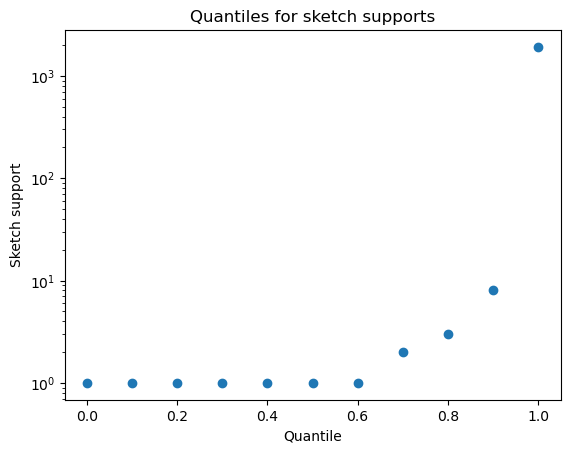

In [8]:
qtls = arange(0, 1.1, 0.1)
plt.scatter(x=qtls, y=quantile(list(sketch_counter.values()),q=qtls))
plt.title('Quantiles for sketch supports')
plt.xlabel('Quantile')
plt.ylabel('Sketch support')
plt.yscale('log')
plt.show()

In [9]:
display(DataFrame({
    'Top sketches': [sketch for sketch, _ in sketch_counter.most_common(50)],
    'Support': [count for _, count in sketch_counter.most_common(50)] 
}))

,Top sketches,Support
0,[V]nsubj(L),1918
1,[S],1891
2,[V]nsubj(L)obl(L),979
3,[V],883
4,[S]cop(L)nsubj:cop(L),853
5,[V]nsubj(L)obj(L),760
6,[V]advmod(L)nsubj(L),663
7,[V]obj(L),594
8,[V]obl(L),557
9,[V]nsubj(L)obj(L)obl(L),534


In [10]:
# Coverage of the 50 most frequent sketches
print('Top 50 sketches coverage:  {:.2f}%'.format(sum([count for _, count in sketch_counter.most_common(50)])/clauses_count_total * 100))

Top 50 sketches coverage:  37.58%


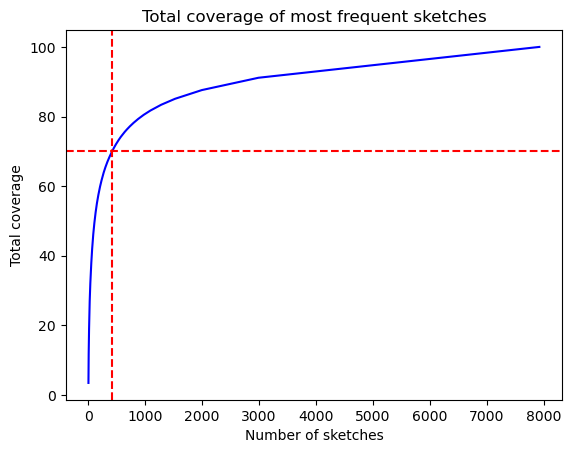

In [11]:
coverage = cumsum(sorted(list(sketch_counter.values()), reverse=True))
coverage = coverage/coverage[-1] * 100

plt.plot(range(1, len(coverage)+1), coverage, color='blue')
plt.axhline(y=70, color='r', linestyle='--')
plt.axvline(x=argmax(coverage >= 70) + 1, color='r', linestyle='--')
plt.title('Total coverage of most frequent sketches')
plt.xlabel('Number of sketches')
plt.ylabel('Total coverage')
plt.show()

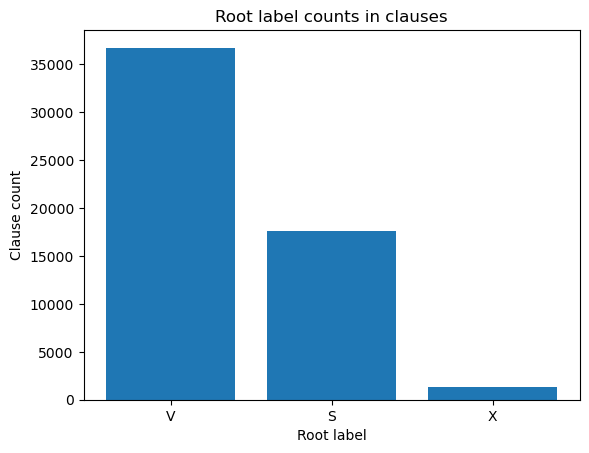

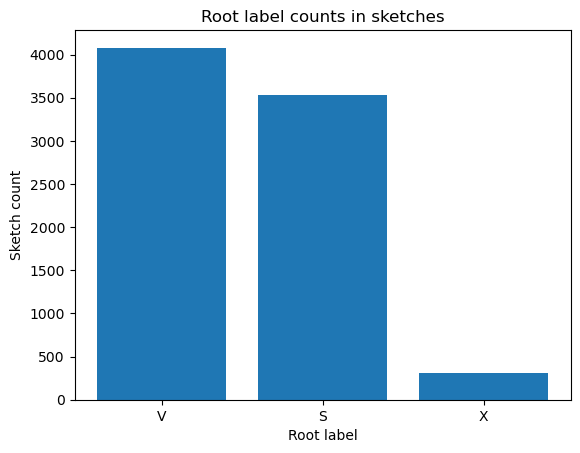

In [12]:
root_counts = dict()
for sketch, count in sketch_counter.items():
    root_counts[sketch[1]] = root_counts.get(sketch[1], 0) + count

plt.bar(range(len(root_counts)), list(root_counts.values()), align='center')
plt.xticks(range(len(root_counts)), list(root_counts.keys()))
plt.title('Root label counts in clauses')
plt.xlabel('Root label')
plt.ylabel('Clause count')
plt.show()

root_counts = dict()
for sketch, count in sketch_counter.items():
    root_counts[sketch[1]] = root_counts.get(sketch[1], 0) + 1
    
plt.bar(range(len(root_counts)), list(root_counts.values()), align='center')
plt.xticks(range(len(root_counts)), list(root_counts.keys()))
plt.title('Root label counts in sketches')
plt.xlabel('Root label')
plt.ylabel('Sketch count')
plt.show()

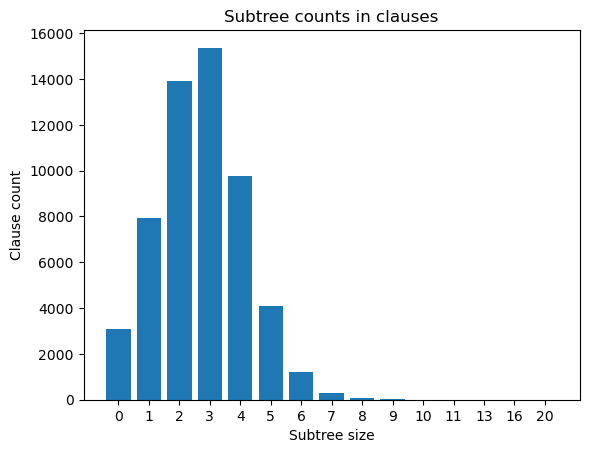

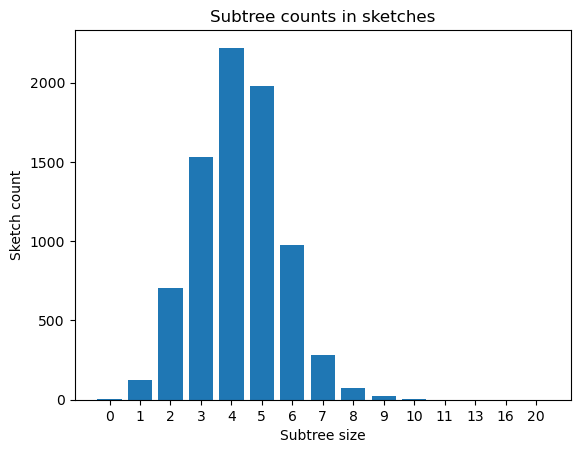

In [13]:
subtree_counts = dict()
for sketch, count in sketch_counter.items():
    subtree_count = sketch.count(')')
    subtree_counts[subtree_count] = subtree_counts.get(subtree_count, 0) + count
subtree_counts = dict(sorted(subtree_counts.items()))    

plt.bar(range(len(subtree_counts)), list(subtree_counts.values()), align='center')
plt.xticks(range(len(subtree_counts)), list(subtree_counts.keys()))
plt.title('Subtree counts in clauses')
plt.xlabel('Subtree size')
plt.ylabel('Clause count')
plt.show() 

subtree_counts = dict()
for sketch, count in sketch_counter.items():
    subtree_count = sketch.count(')')
    subtree_counts[subtree_count] = subtree_counts.get(subtree_count, 0) + 1
subtree_counts = dict(sorted(subtree_counts.items()))    


plt.bar(range(len(subtree_counts)), list(subtree_counts.values()), align='center')
plt.xticks(range(len(subtree_counts)), list(subtree_counts.keys()))
plt.title('Subtree counts in sketches')
plt.xlabel('Subtree size')
plt.ylabel('Sketch count')
plt.show()

## III. Save top 50 sketches for knock-out experiments

In [14]:
DataFrame({
    'sketch': [sketch for sketch, _ in sketch_counter.most_common(50)],
    'support': [count for _, count in sketch_counter.most_common(50)] 
}).to_csv( knockout_list_file )